# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

"How do average salaires compare across different industries?"

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from autoviz.AutoViz_Class import AutoViz_Class

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#your info here
__author__ = "Anthony Wong"
__email__ = "anthonywong2718@gmail.com"

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
train_salary_df = pd.read_csv('data/train_salaries.csv')
train_features_df = pd.read_csv('data/train_features.csv')
test_features_df = pd.read_csv('data/test_features.csv')

In [3]:
train_df = pd.merge(train_features_df, train_salary_df, on='jobId')

In [4]:
train_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [5]:
test_features_df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

#### look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

In [6]:
train_df.duplicated().sum()
test_features_df.duplicated().sum()

0

0

In [7]:
train_df[train_df['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [8]:
train_df.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

There are no duplicates and empty values in the data. The observations where salary is 0 obviously don't properly reflect the situation so we are safe to remove them from the analysis.

In [9]:
train_df = train_df[train_df['salary'] > 0]
train_df.shape

(999995, 9)

In [43]:
train_df.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

### ---- 4 Explore the data (EDA) ----

In [10]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

#### Target Variables

In [11]:
train_df.describe() # summarize each continuous variable

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


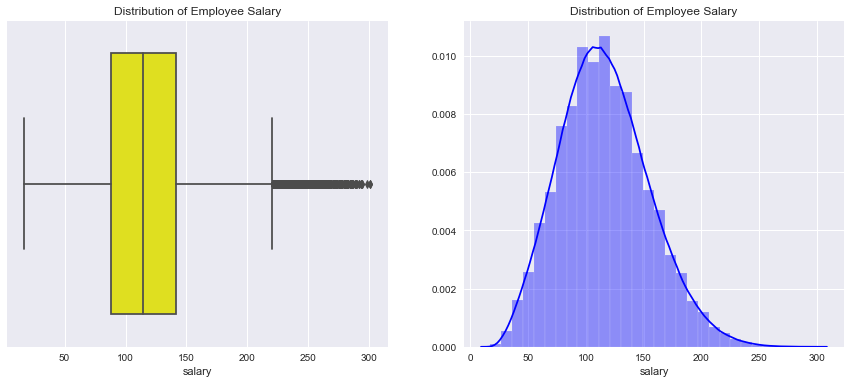

In [15]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary, color='yellow')
plt.title('Distribution of Employee Salary')
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins = 30, color='blue')
plt.title('Distribution of Employee Salary')
plt.show();

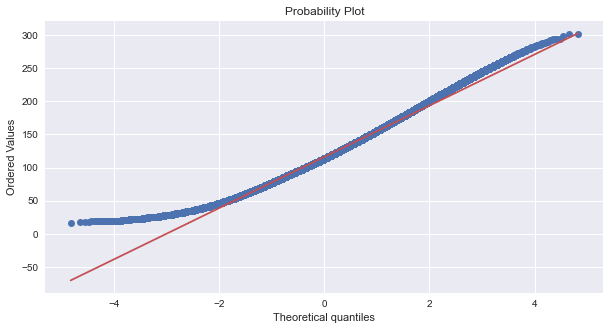

In [16]:
plt.figure(figsize = (10,5))
sp.stats.probplot(train_df.salary, dist='norm', plot=plt) # check for normality
plt.show();

#### Feature Variables

In [14]:
train_df.describe(include=['O']) # summarize each categorical variable

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684904467,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


In [51]:
def plot_feature(df, col):
    """ Make plot for the feature <col> from the data frame <df>.
    """
    plt.figure(figsize = (14, 6))
    if df[col].dtype != 'int64':
        plt.subplot(1, 2, 1)
        # change the categorial variable to category type and order their level by the mean salary in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        mean.sort_values().plot(kind='bar')
        
    if col not in ['companyId', 'yearsExperience', 'milesFromMetropolis']:
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel('Average Salary by' + ' ' + col.capitalize())
        plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64':
        # plot the mean salary for each category and fill between (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    if col not in ['companyId', 'yearsExperience', 'milesFromMetropolis']:
        plt.xticks(rotation=45)
        plt.ylabel('Salaries')
        plt.show()

#### Correlation Between Each Feature and the Target

In [52]:
feat_variables = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

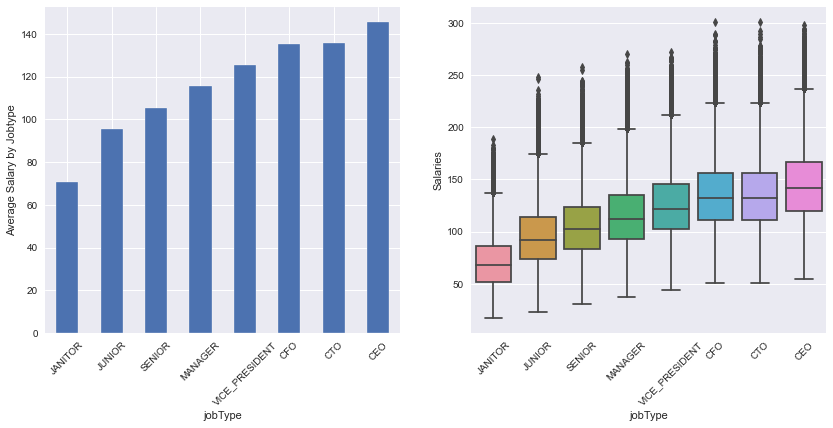

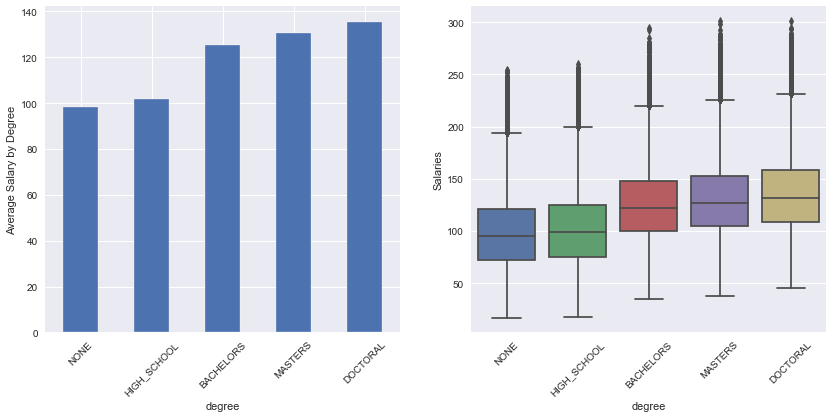

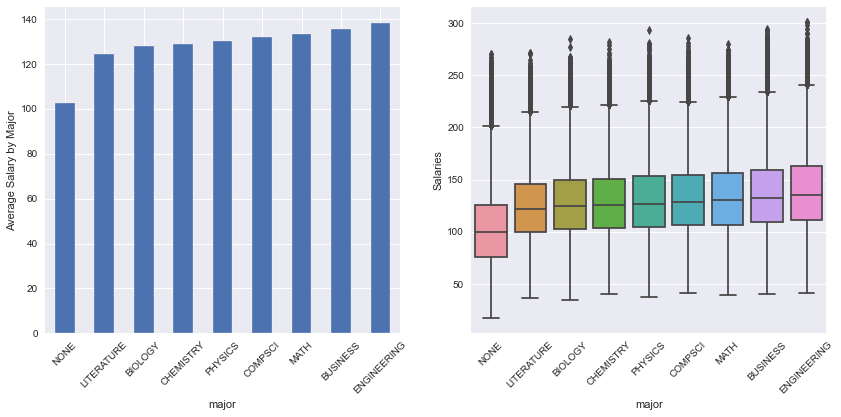

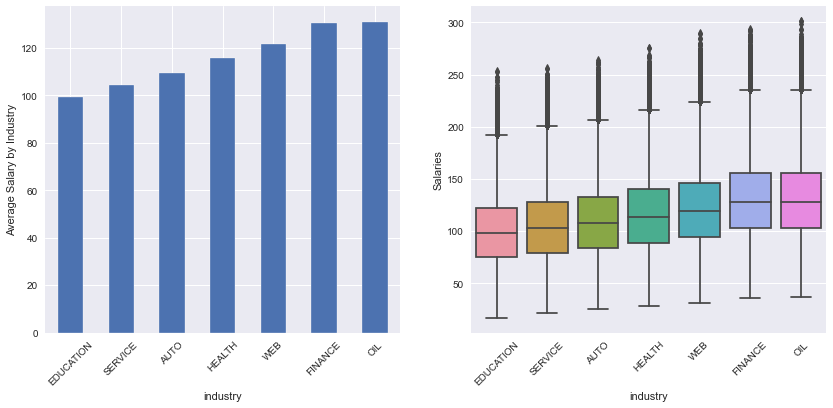

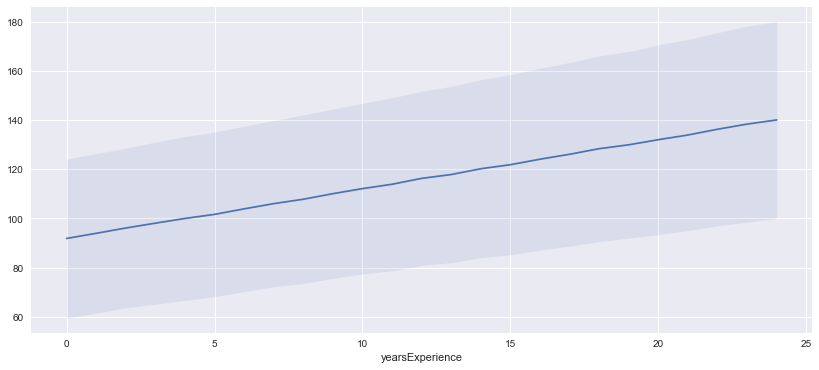

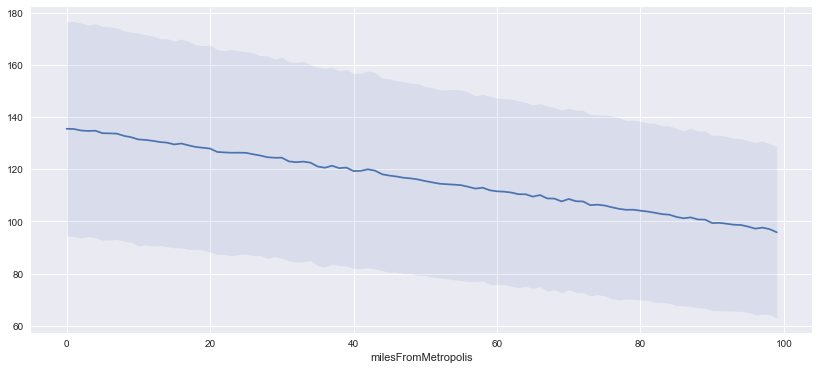

In [53]:
for feature in feat_variables:
    plot_feature(train_df, feature)

A positive correlation can be seen between average salary and the level of job type and of degree; types like those on C-level have high salary average; a higher degree tends to have high average salary. More technical majors like computer science and engineering also tend to have high average salary. Industries like finance and oil also tend to have higher average salary.

Salary has a positive relationship with years of experience and a negative relationship with the distance from metropolis.

### ---- 5 Establish a baseline ----

In [19]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [20]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [21]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [22]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [23]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [24]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [25]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [26]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data